In [73]:
# ## load AEDL// xsec // fluxx filess...




# Parsing AEDL file here  ... to dict



In [74]:
## parsing glb file...to a dictionary type

import re

def strip_comments(line):
    # Remove inline C-style and C++-style comments
    line = re.sub(r"/\*.*?\*/", "", line)
    line = re.sub(r"//.*", "", line)

    # Remove whole line if it starts with #
    if re.match(r"\s*#", line):
        return ""
    return line

def parse_glb(path):
    with open(path, "r") as f:
        raw_lines = f.readlines()

    lines = []
    for line in raw_lines:
        clean = strip_comments(line)
        if clean.strip():
            lines.append(clean.strip())

    config = {}
    current_block = {}
    current_section = None
    current_tag = None
    inside_block = False

    i = 0
    while i < len(lines):
        line = lines[i]

        # Handle block start: inline e.g. nuflux(SPL)< 
        match_inline = re.match(r"(\w+)\(#?([\w\-]+)\)\s*<", line)
        match_header = re.match(r"(\w+)\(#?([\w\-]+)\)", line)

        if not inside_block and match_inline:
            current_section, current_tag = match_inline.groups()
            current_block = {}
            inside_block = True
            i += 1
            continue

        elif not inside_block and match_header:
            # Next line must be <
            if i + 1 < len(lines) and lines[i + 1] == "<":
                current_section, current_tag = match_header.groups()
                current_block = {}
                inside_block = True
                i += 2
                continue

        # Handle end of block
        if inside_block and line == ">":
            if current_section not in config:
                config[current_section] = {}
            config[current_section][current_tag] = current_block
            current_block = {}
            inside_block = False
            i += 1
            continue

        # Parse key-value lines
        kv_match = re.match(r"[\@\$\!]?(\w+)\s*=\s*(.*)", line)
        if kv_match:
            key, val = kv_match.groups()
            val = val.strip().strip('"')

            # Try to convert to float
            try:
                val = float(val)
            except ValueError:
                pass

            if inside_block:
                current_block[key] = val
            else:
                config[key] = val

        i += 1

    return config



In [75]:
glb_config = parse_glb("data/ESS_360_5.glb")
print(glb_config)

{'version': '3.0.0', 'nuflux': {'SPLplus': {'flux_file': 'NuFluxP_GA.txt', 'time': 5.0, 'norm': 1.673e-07}, 'SPLminus': {'flux_file': 'NuFluxM_GA.txt', 'time': 5.0, 'norm': 1.673e-07}}, 'target_mass': '538/0.846445', 'sampling_points': 200.0, 'sampling_min': 0.0, 'sampling_max': 1.5, 'bins': 50.0, 'emin': 0.0, 'emax': 2.5, 'profiletype': 1.0, 'baseline': 360.0, 'filter_state': 0.0, 'filter_value': 0.05, 'energy': {'numucc_as_numucc': {'energy': 'include "matrices/nu_as_nu/30/numu_cc_as_numu_cc.dat'}, 'numunc_as_numucc': {'energy': 'include "matrices/nu_as_nu/30/numu_nc_as_numu_cc.dat'}, 'numucc_as_nuecc': {'energy': 'include "matrices/nu_as_nu/30/numu_cc_as_nue_cc.dat'}, 'nuecc_as_nuecc': {'energy': 'include "matrices/nu_as_nu/30/nue_cc_as_nue_cc.dat'}, 'numunc_as_nuecc': {'energy': 'include "matrices/nu_as_nu/30/numu_nc_as_nue_cc.dat'}, 'nuecc_as_numucc': {'energy': 'include "matrices/nu_as_nu/30/nue_cc_as_numu_cc.dat'}, 'anumucc_as_numucc': {'energy': 'include "matrices/anu_as_nu/30/

# parsed AEDL dict .. to json



In [76]:
## makine json out out glb via dictionary



import json

# Suppose this is your parsed output
parsed_data = parse_glb("data/ESS_360_5.glb")

# Write it to a JSON file
with open("parsed_output1.json", "w") as f:
    json.dump(parsed_data, f, indent=2)


# Probability provider here 


In [77]:
from nufast import Probability_Matter_LBL

class MatterLBLProbabilityProvider:
    def __init__(self, osc_params, rho=2.8, Ye=0.5, N_Newton=5):
        self.params = osc_params
        self.rho = rho
        self.Ye = Ye
        self.N_Newton = N_Newton

    def get(self, init_flavor, final_flavor, energy, baseline):
        result = Probability_Matter_LBL(
            s12sq=self.params['s12sq'],
            s13sq=self.params['s13sq'],
            s23sq=self.params['s23sq'],
            delta=self.params['delta'],
            Dmsq21=self.params['Dmsq21'],
            Dmsq31=self.params['Dmsq31'],
            L=baseline,
            E=energy,
            rho=self.rho,
            Ye=self.Ye,
            N_Newton=self.N_Newton
        )
        return result[(init_flavor, final_flavor)]


In [78]:
nufit_NO = {
    's12sq': 0.304,         # sin^2(theta_12)
    's13sq': 0.02225,       # sin^2(theta_13)
    's23sq': 0.573,         # sin^2(theta_23)
    'delta': 3.77,          # CP phase in radians (~1.2π)
    'Dmsq21': 7.42e-5,      # Δm^2_21 in eV²
    'Dmsq31': 2.517e-3      # Δm^2_31 (normal ordering) in eV²
}


In [92]:
provider = MatterLBLProbabilityProvider(nufit_NO,rho=2.8, Ye=0.5, N_Newton=5)
e = np.linspace(0.1, 200, 10)
provider.get('m', 'e', energy=e, baseline=360)
# workssss

array([1.48041854e-01, 1.14405421e-04, 2.86218077e-05, 1.27227337e-05,
       7.15696378e-06, 4.58059643e-06, 3.18102743e-06, 2.33710914e-06,
       1.78936408e-06, 1.41382720e-06])


#  the FLUX loader 


In [93]:
import numpy as np

class FluxLoader:
    def __init__(self, aedl_data):
        self.flux_info = aedl_data['nuflux']
       
    def load(self, tag, flavor, energy):
        """
        Load and interpolate flux for the given tag and flavor over the specified energy grid.
        Arguments:
            tag (str): e.g., 'SPLplus' or 'SPLminus'
            flavor (str): e.g., 'e', 'm', 'NOSC_m' — currently unused, but can be used if flux files are flavor-dependent.
            energy (np.ndarray): true energy grid to interpolate over

        Returns:
            np.ndarray: interpolated and normalized flux
        """
        if tag not in self.flux_info:
            raise ValueError(f"Flux tag '{tag}' not found in AEDL JSON.")

        entry = self.flux_info[tag]
        filename = entry['flux_file']
        time = float(entry['time'])          # years
        norm = float(entry['norm'])          # normalization factor

################## unsure of this flavour map ..??
        flavor_column_map = {
                                'e': 1,         # νμ
                                'm': 2,         # νe
                                't': 3,         # ντ
                                'ae': 4,        # anti-νμ
                                'am': 5,        # anti-νe
                                'at': 6         # anti-ντ
                            }

        
        # Load file: assume columns = [energy (GeV), flux]
        
        flux_data = np.loadtxt(filename)
        column = flavor_column_map.get(flavor)
        if column is None:
            raise ValueError(f"Unsupported flavor: {flavor}")
        
        energy_vals = flux_data[:, 0]
        flux_vals = flux_data[:, column]

        

        # Interpolate to requested energy grid
        flux_interp = np.interp(energy, energy_vals, flux_vals, left=0, right=0)  
        # Apply norm and time scaling
        return norm * time * flux_interp


Flux at 0.0 GeV in SPLplus mode = 0.0


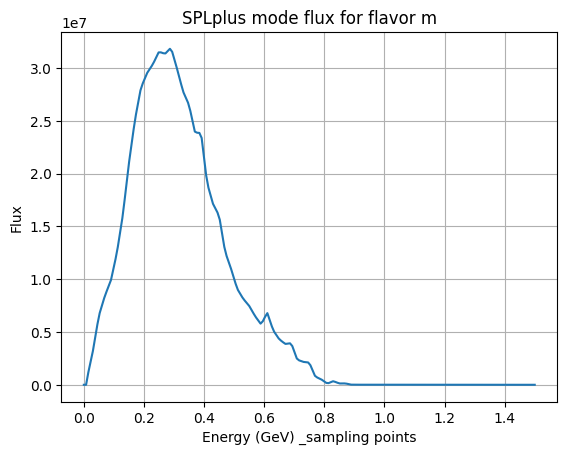

In [94]:
## testin FLUX loader.. looks like it works  

import numpy as np
import json

# Load the AEDL JSON data
with open("parsed_output.json") as f:
    aedl_data = json.load(f)

# Create the loader instance
flux_loader = FluxLoader(aedl_data)

# Pick a known channel and test with a sample energy
tag = "SPLplus"           # or "SPLminus"
flavor = "m"              # flavor is not used right now, but passed in

sampling_points = int(aedl_data['sampling_points'])
sampling_min = float(aedl_data['sampling_min'])
sampling_max = float(aedl_data['sampling_max'])
true_energy = np.linspace(sampling_min,sampling_max, sampling_points)

# energy_val = 0.4          # test energy
# energy_array = np.array([energy_val])
energy_array= true_energy

# Call the loader
try:
    flux = flux_loader.load(tag=tag, flavor=flavor, energy=energy_array)
    print(f"Flux at {energy_array[0]} GeV in {tag} mode = {flux[0]}")
    # print(f"Flux at {energy_array[1]} GeV in {tag} mode = {flux[1]}")
    # print(f"Flux at {energy_array[2]} GeV in {tag} mode = {flux[2]}")
except Exception as e:
    print("Error:", e)


import matplotlib.pyplot as plt

plt.plot(energy_array, flux)
plt.xlabel("Energy (GeV) _sampling points")
plt.ylabel("Flux")
plt.title(f"{tag} mode flux for flavor {flavor}")
plt.grid(True)
plt.show()

# cross section loader for channel

In [95]:
import numpy as np

class CrossSectionLoader:
    def load(self, filename, flavor, energy):
        """
        Load and interpolate neutrino cross section from a log10(E)-based file,
        with xsec/E values. Returns total xsec in cm^2.

        Args:
            filename (str): path to the cross section file
            flavor (str): 'e', 'm', 't', 'ae', 'am', 'at'
            energy (np.ndarray): true energy grid in GeV

        Returns:
            np.ndarray: total cross section values in cm^2
        """

        # Column mapping based on file structure
        flavor_column_map = {
            'e': 1,   # νe
            'm': 2,   # νμ
            't': 3,   # ντ
            'ae': 4,  # anti-νe
            'am': 5,  # anti-νμ
            'at': 6   # anti-ντ
        }

        col = flavor_column_map.get(flavor)
        if col is None:
            raise ValueError(f"Unsupported flavor: {flavor}")

        # Load data and convert log10(E) → E
        raw = np.loadtxt(filename, comments="#")
        log10_E = raw[:, 0]
        E_vals = 10 ** log10_E  # Energy in GeV
        xsec_per_E = raw[:, col]  # xsec/E in 10^-38 cm^2 / GeV

        # Compute total xsec = (xsec/E) × E
        xsec_vals = xsec_per_E * E_vals

        # Interpolate to requested energy grid
        xsec_interp = np.interp(energy, E_vals, xsec_vals, left=0, right=0)

        # Scale to cm² — already in 10^-38, so multiply by 1e-38 if needed
        return xsec_interp * 1e-38


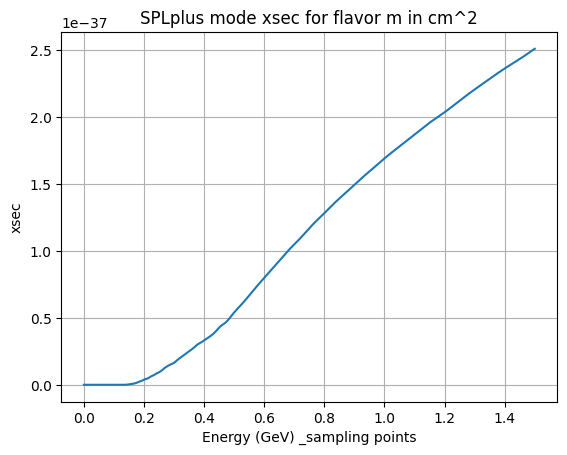

In [96]:
xsec_loader = CrossSectionLoader()


xsec = xsec_loader.load(
    filename="essnusb_xsec_CC-GENIE-3_00_06-G18_10a_00_000.txt",
    flavor="m",
    energy=true_energy
)
plt.plot(true_energy, xsec)
plt.xlabel("Energy (GeV) _sampling points")
plt.ylabel("xsec")
plt.title(f"{tag} mode xsec for flavor {flavor} in cm^2")
plt.grid(True)
plt.show()

# smear loader for channel

In [97]:
import numpy as np
import os
import re

class SmearingMatrixLoader:
    def __init__(self, base_path=None):
        self.base_path = base_path
        self.cache = {}
    def load(self, smear_file):
        path = os.path.join(self.base_path, smear_file) if self.base_path else smear_file
    
        if path in self.cache:
            return self.cache[path]
    
        try:
            with open(path) as f:
                lines = f.readlines()
    
            matrix = []
            for line in lines:
                line = line.strip()
                if not line.startswith("{"):
                    continue
    
                # Remove leading '{' and trailing '}', '};', or '}:'
                if line.endswith("};") or line.endswith("}:"):
                    line = line[1:-2]
                elif line.endswith("}"):
                    line = line[1:-1]
                else:
                    line = line[1:]
    
                values = [float(x.strip()) for x in line.split(',') if x.strip()]
                matrix.append(values)
    
            matrix = np.array(matrix)
    
        except Exception as e:
            raise IOError(f"Failed to load smearing matrix from '{path}': {e}")
    
        self.cache[path] = matrix
        return matrix




In [98]:
# smear_loader = SmearingMatrixLoader(base_path=None)  # or None if full path

# # Load the smearing matrix for the given channel
# smear_matrix = smear_loader.load(ch['smear_file'])
# smear_matrix.shape
# smear_matrix[-1],ch['smear_file']


#  a rate calculator 


In [103]:
import numpy as np
from collections import defaultdict

class RateCalculator:
    def __init__(self, aedl_data, flux_loader, cross_section_loader, smearing_loader, probability_provider):
        self.data = aedl_data   # call from json
        self.flux_loader = flux_loader
        self.cross_section_loader = cross_section_loader
        self.smearing_loader = smearing_loader
        self.probability_provider = MatterLBLProbabilityProvider(nufit_NO)  #implemented

        self.sampling_points = int(aedl_data['sampling_points'])
        self.sampling_min = float(aedl_data['sampling_min'])
        self.sampling_max = float(aedl_data['sampling_max'])
        self.true_energy = np.linspace(self.sampling_min, self.sampling_max, self.sampling_points)

        self.bins = int(aedl_data['bins'])
        self.emin = float(aedl_data['emin'])
        self.emax = float(aedl_data['emax'])
        self.reco_energy = np.linspace(self.emin, self.emax, self.bins + 1)

        self.target_mass = eval(aedl_data['target_mass'])  # in kt
        self.N_Avogadro = 6.022e23
        self.N_targets = self.target_mass * 1e3 * self.N_Avogadro  # converting kt to g

        self.channels = self._parse_channels()

    def _parse_channels(self):
        channels = {}
        for ch_name, ch_data in self.data['channel'].items():
            tag = ch_data['channel'].replace('#', '').split(':')
            flux_tag, polarity, init_flav, final_flav, int_type, smear_key = [t.strip() for t in tag]
            smear_file = self.data['energy'][smear_key]['energy'].split('"')[1]
            xsec_file = self.data['cross'][int_type]['cross_file']
    
            channels[ch_name] = {
                'flux_tag': flux_tag,
                'polarity': polarity,
                'init_flav': init_flav,
                'final_flav': final_flav,
                'int_type': int_type,
                'smear_file': smear_file,
                'xsec_file': xsec_file
            }
        return channels

    
    def smeared_rate_per_channel(self, ch, prob_table=None):
        # --- Load flux ---
        flux = self.flux_loader.load(
            tag=ch['flux_tag'],
            flavor=ch['init_flav'],
            energy=self.true_energy
        )
    
        # --- Get oscillation probability ---
        prob = self.probability_provider.get(
            init_flavor=ch['init_flav'],
            final_flavor=ch['final_flav'],
            energy=self.true_energy,
            baseline=float(self.data['baseline'])
        )
    
        # --- Apply probability to flux ---
        flux *= prob
    
        # --- Load cross section ---
        xsec = self.cross_section_loader.load(
            ch['xsec_file'],
            flavor=ch['final_flav'],
            energy=self.true_energy
        )
    
        # --- Compute interaction rate in true energy ---
        rate_true = flux * xsec * self.N_targets
    
        # --- Apply smearing ---
        smear_matrix = self.smearing_loader.load(ch['smear_file'])
        # print(f"rate_true shape: {rate_true.shape}")
        # print(f"smear_matrix shape: {smear_matrix.shape}")
        rate_reco = smear_matrix @ rate_true
       
        return  rate_reco     #   rate_true





In [100]:
# ch['smear_file']

# testing _parse_channels from   RateCalculator
  # testing smeared_rate_per_channel from   RateCalculator

In [104]:
# testing _parse_channels from   RateCalculator
  # testing smeared_rate_per_channel from   RateCalculator


import numpy as np
import json

with open("parsed_output.json") as f:
    aedl_data = json.load(f)

nufit_NO = {
    's12sq': 0.304,         # sin^2(theta_12)
    's13sq': 0.02225,       # sin^2(theta_13)
    's23sq': 0.573,         # sin^2(theta_23)
    'delta': 3.77,          # CP phase in radians (~1.2π)
    'Dmsq21': 7.42e-5,      # Δm^2_21 in eV²
    'Dmsq31': 2.517e-3      # Δm^2_31 (normal ordering) in eV²
}


# smear_loader = SmearingMatrixLoader(base_path=None)  # or None if full path

# # Load the smearing matrix for the given channel
# smear_matrix = smear_loader.load(ch['smear_file'])
# smear_matrix

# Now instantiate your RateCalculator
rc = RateCalculator(
    aedl_data,
    flux_loader=FluxLoader(aedl_data),
    cross_section_loader=CrossSectionLoader(),
    smearing_loader=SmearingMatrixLoader(base_path=None) ,
    probability_provider=MatterLBLProbabilityProvider(nufit_NO)
)

# Print parsed channels to verify  
from pprint import pprint
# pprint(rc.channels)

# for ch_name, ch in rc.channels.items():
#     print(ch_name , "  " , ch['final_flav'] ,"")
#     print(ch_name , "  " , ch['init_flav'] ," \n")

# # rc.channels['nue_appCC']['final_flav']
# # rc.channels['nue_appCC'] 
ch = rc.channels['nue_appCC'] 

ch
rate = rc.smeared_rate_per_channel(ch)

# Check the result
print(f"Smeared rate shape: {rate.shape}")
print(f"First 10 values:\n{rate[:10]}")

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 200 is different from 202)

In [102]:
sampling_points = int(aedl_data['sampling_points'])
sampling_points

200

In [90]:
smear_loader = SmearingMatrixLoader(base_path=None)  # or None if full path

# Load the smearing matrix for the given channel
smear_matrix = smear_loader.load(ch['smear_file'])
smear_matrix

array([[0.00000e+00, 1.99000e+02, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [0.00000e+00, 1.99000e+02, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [0.00000e+00, 1.99000e+02, 0.00000e+00, ..., 1.00980e-04,
        1.00980e-04, 1.00980e-04],
       ...,
       [0.00000e+00, 1.99000e+02, 0.00000e+00, ..., 1.36322e-03,
        1.36322e-03, 1.36322e-03],
       [0.00000e+00, 1.99000e+02, 0.00000e+00, ..., 1.41371e-03,
        1.41371e-03, 1.41371e-03],
       [0.00000e+00, 1.99000e+02, 0.00000e+00, ..., 1.21175e-03,
        1.21175e-03, 1.21175e-03]], shape=(50, 202))

In [ ]:

#### rule based calculation .. this one is the actuall stuffffff


def compute_rule_event_rate(rule_name):
    rule = rules[rule_name]
    rate_reco = np.zeros(len(reconstructed_energy_bins))

    # --- 1. Loop over signal channels ---
    for entry in rule['signal']:
        weight, ch_name = parse(entry)  # e.g., "1.0@#nue_bar_appCC"
        ch = channels[ch_name]

        rate_reco += weight * smeared_rate_per_channel(ch)

    # --- 2. Loop over background channels ---
    for entry in rule['background']:
        weight, ch_name = parse(entry)  # e.g., "1.0@#numu_bar_miss_ID"
        ch = channels[ch_name]

        rate_reco += weight * smeared_rate_per_channel(ch)

    # --- 3. Apply energy window ---
    reco_energy = reconstructed_energy_bins  # assumed global or passed in
    mask = (reco_energy >= rule['emin']) & (reco_energy <= rule['emax'])
    rate_windowed = rate_reco[mask]

    return rate_windowed

200

In [37]:
# import json

# with open("parsed_output.json") as f:
#     aedl_data = json.load(f)



